In [260]:
from src.model import FloodPrediction

In [261]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix

In [262]:
# create a model for testing
new_model = FloodPrediction(path="./data/")

Total: 1452; positive: 8 (0.55% of total)


In [263]:
# stats
print(new_model.get_dataframe()[['months_rain', 'months_flood']].describe())

       months_rain  months_flood
count  1452.000000   1452.000000
mean    102.658846      0.005510
std     146.448407      0.074048
min       0.000000      0.000000
25%       3.891515      0.000000
50%      50.316214      0.000000
75%     135.978452      0.000000
max    1061.642222      1.000000


In [264]:
# check shape
print("Original shape:", new_model.get_dataframe().shape)

Original shape: (1452, 2)


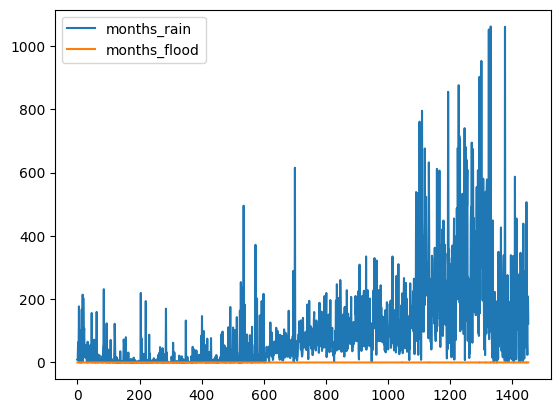

In [265]:
# visualise data
new_model.get_dataframe().plot()
plt.show()

In [266]:
# check shape after sampling target data
print("X:", new_model.get_data().shape)
print("y:", new_model.get_target().shape)

X: (266, 20, 2)
y: (266, 1)


In [267]:
# display targets
print("Y", new_model.get_target())

Y [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [

In [268]:
# check shape after splitting
print("X_train:", new_model.get_data_train_split().shape, "X_test:", new_model.get_data_test_split().shape)
print("y_train:", new_model.get_target_train_split().shape, "y_test:", new_model.get_target_test_split().shape)
print("X_val:", new_model.get_data_validation_split().shape, "y_val:", new_model.get_target_validation_split().shape)

X_train: (190, 20, 2) X_test: (54, 20, 2)
y_train: (190, 1) y_test: (54, 1)
X_val: (22, 20, 2) y_val: (22, 1)


In [269]:
# hyperparameter search
new_model.tune_model()

Reloading Tuner from ./untitled_project/tuner0.json
320 0.001


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 20, 320)        │       413,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 32)             │        45,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,657 (1.75 MB)

 Trainable params: 458,657 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - FN: 21.4188 - FP: 4.8429 - TN: 67.1623 - TP: 56.5707 - accuracy: 0.8230 - log loss: 0.5470 - loss: 1.0279 - prc: 0.9171 - precision: 0.9277 - recall: 0.7119 - val_FN: 0.0000e+00 - val_FP: 0.0000e+00 - val_TN: 12.0000 - val_TP: 10.0000 - val_accuracy: 1.0000 - val_log loss: 0.0335 - val_loss: 0.0335 - val_prc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - FN: 5.7173 - FP: 1.5026 - TN: 43.7277 - TP: 45.0471 - accuracy: 0.9340 - log loss: 0.2302 - loss: 0.2302 - prc: 0.9838 - precision: 0.9691 - recall: 0.9019 - val_FN: 0.0000e+00 - val_FP: 0.0000e+00 - val_TN: 12.0000 - val_TP: 10.0000 - val_accuracy: 1.0000 - val_log loss: 0.0196 - val_loss: 0.0196 - val_prc: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/20
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - FN: 1.1309 - FP: 0.0000e+00 - TN: 40.9058 - TP: 53.9581 - accuracy: 0.9904 - log loss: 0.0634 - loss: 0.0634 - pr

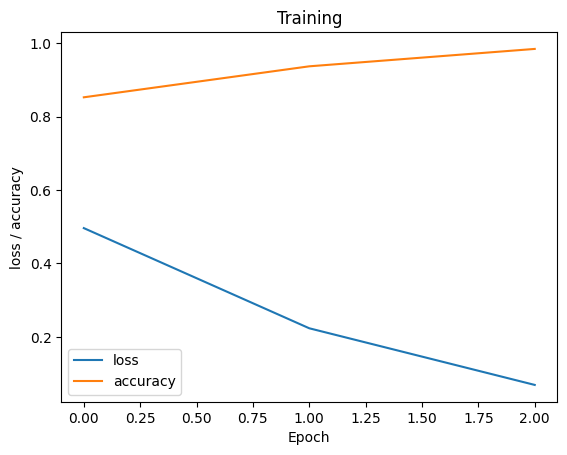

In [270]:
# training
new_model.fit_model()
plt.plot(new_model.get_history().history['loss'])
plt.plot(new_model.get_history().history['accuracy'])
plt.ylabel("loss / accuracy")
plt.xlabel("Epoch")
plt.legend(['loss', 'accuracy'])
plt.title("Training")
plt.show()

In [271]:
# make prediction
y_pred = new_model.predict()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


In [272]:
# evaluate prediction
new_model.evaluate()
y_test = new_model.get_target_test_split()
print("Actual:")
print(pd.DataFrame(y_test, columns=list(new_model.get_dataframe()[new_model.get_dataframe().columns[-1:]])))
print("Predictions:")
print(y_pred)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - FN: 1.3333 - FP: 0.0000e+00 - TN: 23.0000 - TP: 22.3333 - accuracy: 0.9753 - log loss: 0.1501 - loss: 0.1501 - prc: 0.9839 - precision: 1.0000 - recall: 0.9506     
Actual:
    months_flood
0            1.0
1            0.0
2            1.0
3            1.0
4            0.0
5            1.0
6            1.0
7            0.0
8            0.0
9            0.0
10           0.0
11           0.0
12           1.0
13           1.0
14           1.0
15           0.0
16           0.0
17           0.0
18           0.0
19           0.0
20           0.0
21           1.0
22           1.0
23           1.0
24           1.0
25           1.0
26           0.0
27           0.0
28           1.0
29           1.0
30           1.0
31           1.0
32           0.0
33           0.0
34           1.0
35           0.0
36           1.0
37           0.0
38           0.0
39           0.0
40           0.0
41           1.0
42           1.0
43           1.0
44           0.0
45   

In [273]:
import seaborn as sns

Text(50.722222222222214, 0.5, 'Predicted')

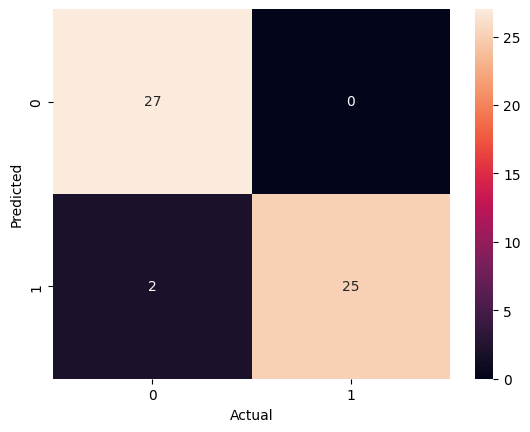

In [274]:
# confusion matrix
conmat = confusion_matrix(y_test, y_pred)
sns.heatmap(conmat, annot=True)
plt.xlabel("Actual")
plt.ylabel("Predicted")